In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

from ensemble import RandomForestClassifier as MyRandomForestClassifier

SEED = 42

# Preprocessing

In [2]:
df = pd.read_csv("hf://datasets/SIH/palmer-penguins/penguins.csv")
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
le = LabelEncoder()
scaler = StandardScaler()
categorical_columns = ['species', 'island', 'sex', 'year']
numerical_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
target = 'species'
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode(dropna=True).iloc[0])
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
for cat in categorical_columns:
    df[cat] = le.fit_transform(df[cat])

In [4]:
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,2,-8.870812e-01,0.787743,-1.422488,-0.565789,1,0
1,0,2,-8.134940e-01,0.126556,-1.065352,-0.503168,0,0
2,0,2,-6.663195e-01,0.431719,-0.422507,-1.192003,0,0
3,0,2,-1.307172e-15,0.000000,0.000000,0.000000,1,0
4,0,2,-1.328605e+00,1.092905,-0.565361,-0.941517,0,0


In [5]:
y = df[target].to_numpy()
X = df.drop(columns=target).to_numpy()

# Train & Validation

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [7]:
accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, average='macro')
recall_scorer = make_scorer(recall_score, average='macro')

n_estimators_range = range(1, 201, 20)

In [8]:
def fit(clf_, n_estimators_range, clf_type_:str = 'my'):
    accuracies = []
    precisions = []
    recalls = []

    for n in n_estimators_range:
        if clf_type_ == 'my':
            clf = clf_(estimator=DecisionTreeClassifier, n_estimators=n, random_state=SEED)
        elif clf_type_ == 'sk':
            clf = RandomForestClassifier(n_estimators=n, random_state=SEED, n_jobs=-1)
        else:
            raise ValueError(f'Unknown clf type {clf_type_}, try "my" or "sk"')
        
        acc = cross_val_score(clf, X, y, cv=cv, scoring=accuracy_scorer)
        prec = cross_val_score(clf, X, y, cv=cv, scoring=precision_scorer)
        rec = cross_val_score(clf, X, y, cv=cv, scoring=recall_scorer)

        accuracies.append(acc.mean())
        precisions.append(prec.mean())
        recalls.append(rec.mean())

    return accuracies, precisions, recalls

In [9]:
def plot_metrics(range_, metric_arrays_, labels_, title:str = 'title'):
    plt.figure(figsize=(12, 6))

    for i in range(len(metric_arrays_)):
        if labels_[i] is None:
            labels_[i] = 'Metric'
        plt.plot(range_, metric_arrays_[i], label=labels_[i])

    plt.xlabel('Number of Estimators')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
my_acc, my_prec, my_recc = fit(MyRandomForestClassifier, n_estimators_range, clf_type_='my')

In [11]:
sk_acc, sk_prec, sk_recc = fit(RandomForestClassifier, n_estimators_range, clf_type_='sk')

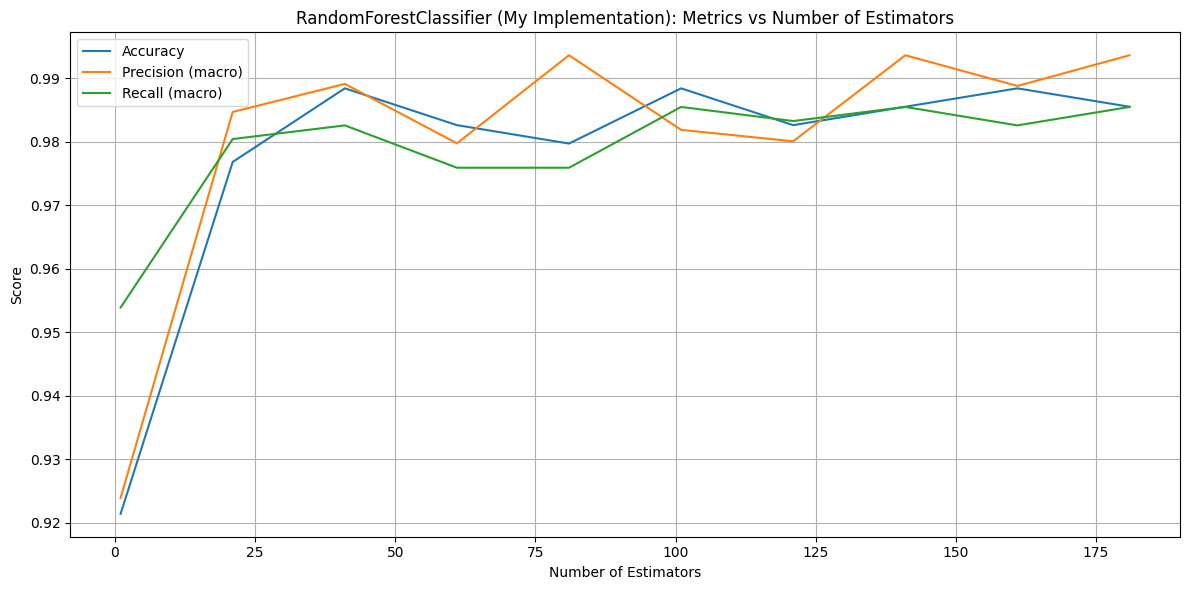

In [12]:
plot_metrics(
    n_estimators_range, 
    [my_acc, my_prec, my_recc], 
    ['Accuracy', 'Precision (macro)', 'Recall (macro)'],
    'RandomForestClassifier (My Implementation): Metrics vs Number of Estimators'
    )

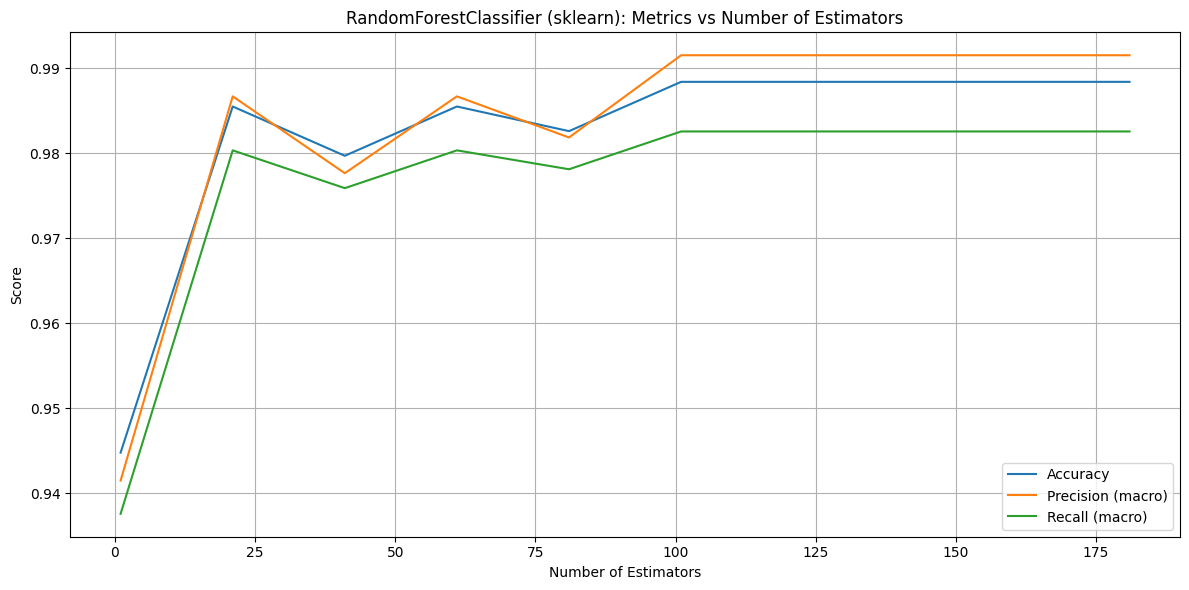

In [13]:
plot_metrics(
    n_estimators_range, 
    [sk_acc, sk_prec, sk_recc], 
    ['Accuracy', 'Precision (macro)', 'Recall (macro)'],
    'RandomForestClassifier (sklearn): Metrics vs Number of Estimators'
    )

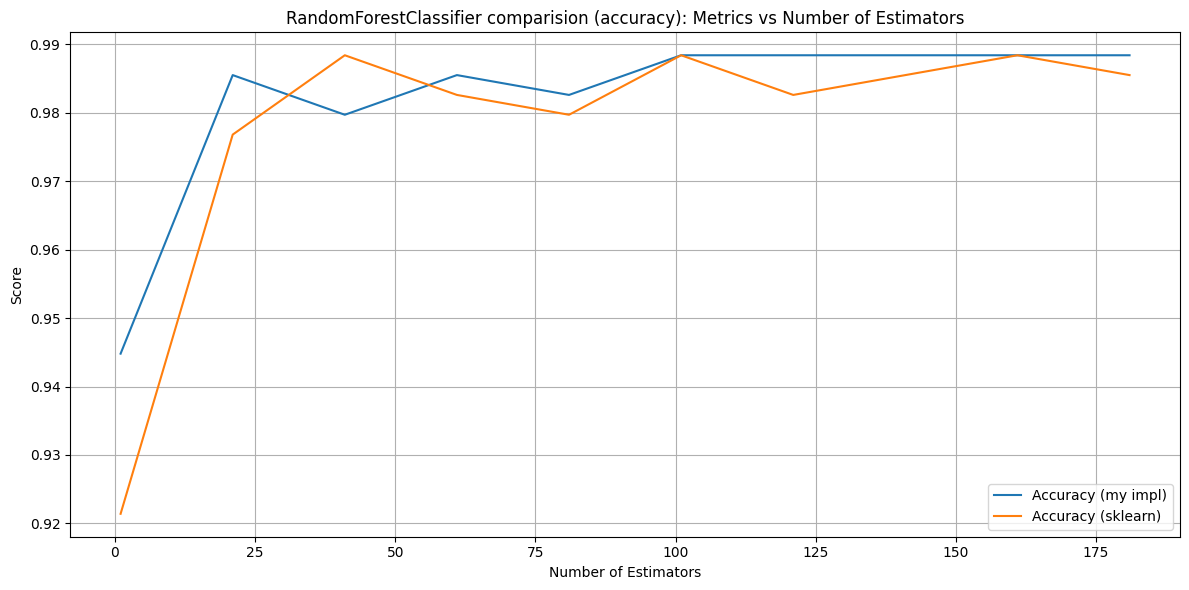

In [14]:
plot_metrics(
    n_estimators_range, 
    [sk_acc, my_acc], 
    ['Accuracy (my impl)', 'Accuracy (sklearn)'],
    'RandomForestClassifier comparision (accuracy): Metrics vs Number of Estimators'
    )

In [15]:
def print_best_metrics(acc, prec, rec, n_estimators_range, model_name='Model'):
    best_idx = np.argmax(acc)
    print(f'🔍 Best metrics for {model_name}')
    print(f'n_estimators = {n_estimators_range[best_idx]}')
    print(f'  ✅ Accuracy : {acc[best_idx]:.4f}')
    print(f'  🎯 Precision: {prec[best_idx]:.4f}')
    print(f'  📢 Recall   : {rec[best_idx]:.4f}')
    print('-' * 40)


In [16]:
print_best_metrics(my_acc, my_prec, my_recc, n_estimators_range, model_name='MyRandomForestClassifier')
print_best_metrics(sk_acc, sk_prec, sk_recc, n_estimators_range, model_name='Sklearn RandomForestClassifier')

🔍 Best metrics for MyRandomForestClassifier
n_estimators = 41
  ✅ Accuracy : 0.9884
  🎯 Precision: 0.9891
  📢 Recall   : 0.9826
----------------------------------------
🔍 Best metrics for Sklearn RandomForestClassifier
n_estimators = 101
  ✅ Accuracy : 0.9884
  🎯 Precision: 0.9915
  📢 Recall   : 0.9826
----------------------------------------


In [17]:
def benchmark(clf_, n_estimators_range, clf_type_: str = 'my'):
    fit_times = []
    predict_times = []

    for n in n_estimators_range:
        if clf_type_ == 'my':
            clf = clf_(estimator=DecisionTreeClassifier, n_estimators=n, random_state=SEED)
        elif clf_type_ == 'sk':
            clf = RandomForestClassifier(n_estimators=n, random_state=SEED, n_jobs=-1)
        else:
            raise ValueError(f'Unknown clf type {clf_type_}, try "my" or "sk"')

        start_fit = time.time()
        clf.fit(X, y)
        end_fit = time.time()

        start_pred = time.time()
        clf.predict(X)
        end_pred = time.time()

        fit_times.append(end_fit - start_fit)
        predict_times.append(end_pred - start_pred)

    return fit_times, predict_times


In [18]:
my_fit_times, my_pred_times = benchmark(MyRandomForestClassifier, n_estimators_range, clf_type_='my')
sk_fit_times, sk_pred_times = benchmark(RandomForestClassifier, n_estimators_range, clf_type_='sk')

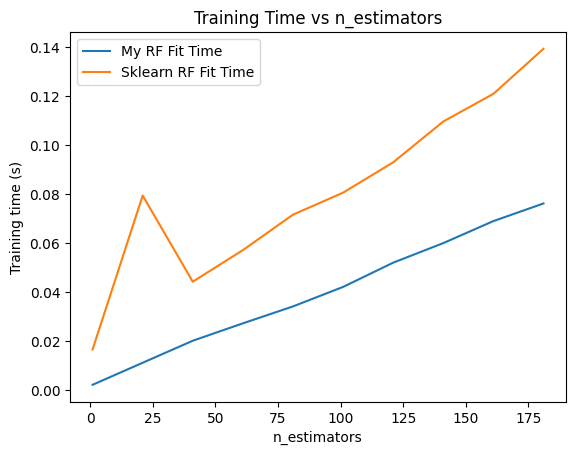

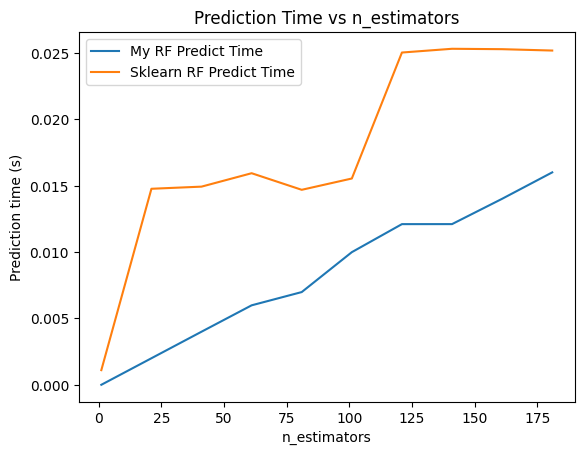

In [19]:
plt.plot(n_estimators_range, my_fit_times, label='My RF Fit Time')
plt.plot(n_estimators_range, sk_fit_times, label='Sklearn RF Fit Time')
plt.xlabel('n_estimators')
plt.ylabel('Training time (s)')
plt.title('Training Time vs n_estimators')
plt.legend()
plt.show()

plt.plot(n_estimators_range, my_pred_times, label='My RF Predict Time')
plt.plot(n_estimators_range, sk_pred_times, label='Sklearn RF Predict Time')
plt.xlabel('n_estimators')
plt.ylabel('Prediction time (s)')
plt.title('Prediction Time vs n_estimators')
plt.legend()
plt.show()
